In [4]:
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
import copy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


0
1
2
3
4
5
6
7
8
9


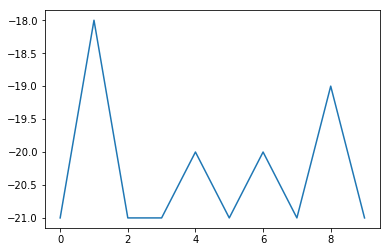

-20.3


In [5]:
%matplotlib inline
env = gym.make('Pong-ram-v0')
episodes = 10
remember = []
episode_numbers = []
for i in range(episodes):
    print(i)
    episode_numbers.append(i)
    observed = env.reset()
    done = False
    Return = 0
    while(done!=True):
#         env.render()
        action = np.random.randint(env.action_space.n)
        observed, reward, done, info = env.step(action)
        Return += reward
    remember.append(Return)
plt.plot(episode_numbers, remember)
plt.show()
print(np.mean(np.array(remember)))

In [6]:
class Trejectory:
    def __init__(self, state, action, next_state, reward):
        self.state = state
        self. action = action
        self.next_state = next_state
        self.reward = reward

In [7]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size
        self.memory = []
        self.front = -1
    
    def push(self, *args):
        if self.__len__()<self.size:
            self.memory.append(Trejectory(*args))
        self.front = (self.front+1)%self.size
    
    def __len__(self):
        return len(self.memory)
    
    def uniform_sample(self, batch):
        return np.random.choice(self.memory, batch, replace=False)
    

In [8]:
def sample_n_unique(sampling_f, n):
    res = []
    while len(res) < n:
        candidate = sampling_f()
        if candidate not in res:
            res.append(candidate)
    return res

In [9]:
class ReplayBuffer(object):
    def __init__(self, size, frame_history_len):
        self.size = size
        self.frame_history_len = frame_history_len

        self.next_idx      = 0
        self.num_in_buffer = 0

        self.obs      = None
        self.action   = None
        self.reward   = None
        self.done     = None

    def can_sample(self, batch_size):
        return batch_size + 1 <= self.num_in_buffer

    def _encode_sample(self, idxes):
        obs_batch      = np.concatenate([self._encode_observation(idx)[np.newaxis, :] for idx in idxes], 0)
        act_batch      = self.action[idxes]
        rew_batch      = self.reward[idxes]
        next_obs_batch = np.concatenate([self._encode_observation(idx + 1)[np.newaxis, :] for idx in idxes], 0)
        done_mask      = np.array([1.0 if self.done[idx] else 0.0 for idx in idxes], dtype=np.float32)

        return obs_batch, act_batch, rew_batch, next_obs_batch, done_mask


    def sample(self, batch_size):
        assert self.can_sample(batch_size)
        idxes = sample_n_unique(lambda: random.randint(0, self.num_in_buffer - 2), batch_size)
        return self._encode_sample(idxes)

    def encode_recent_observation(self):
        assert self.num_in_buffer > 0
        return self._encode_observation((self.next_idx - 1) % self.size)

    def _encode_observation(self, idx):
        end_idx   = idx + 1 # make noninclusive
        start_idx = end_idx - self.frame_history_len
        if len(self.obs.shape) == 2:
            return self.obs[end_idx-1]
        if start_idx < 0 and self.num_in_buffer != self.size:
            start_idx = 0
        for idx in range(start_idx, end_idx - 1):
            if self.done[idx % self.size]:
                start_idx = idx + 1
        missing_context = self.frame_history_len - (end_idx - start_idx)
        if start_idx < 0 or missing_context > 0:
            frames = [np.zeros_like(self.obs[0]) for _ in range(missing_context)]
            for idx in range(start_idx, end_idx):
                frames.append(self.obs[idx % self.size])
            return np.concatenate(frames, 0)
        else:
            img_h, img_w = self.obs.shape[2], self.obs.shape[3]
            return self.obs[start_idx:end_idx].reshape(-1, img_h, img_w)

    def store_frame(self, frame):
        if len(frame.shape) > 1:
            frame = frame.transpose(2, 0, 1)

        if self.obs is None:
            self.obs      = np.empty([self.size] + list(frame.shape), dtype=np.uint8)
            self.action   = np.empty([self.size], dtype=np.int32)
            self.reward   = np.empty([self.size], dtype=np.float32)
            self.done     = np.empty([self.size], dtype=np.bool)

        self.obs[self.next_idx] = frame

        ret = self.next_idx
        self.next_idx = (self.next_idx + 1) % self.size
        self.num_in_buffer = min(self.size, self.num_in_buffer + 1)

        return ret

    def store_effect(self, idx, action, reward, done):
        self.action[idx] = action
        self.reward[idx] = reward
        self.done[idx]   = done

In [10]:
class DQN:
    def __init__(self, input_dim=4, output_dim=18):
        super(DQN, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.conv1 = nn.Conv2d(input_dim, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, output_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))
        return self.fc5(x)
    

In [14]:
env = gym.make('Pong-ram-v0')
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
print(input_dim, output_dim)
Statistic = {
    "mean_episode_rewards": [],
    "best_mean_episode_rewards": []
}

128 6


In [21]:
def select_epilson_greedy_action(model, obs, t):
        sample = random.random()
        eps_threshold = exploration.value(t)
        if sample > eps_threshold:
            obs = torch.from_numpy(obs).type(dtype).unsqueeze(0) / 255.0
            return model(Variable(obs, volatile=True)).data.max(1)[1].cpu()
        else:
            return torch.IntTensor([[random.randrange(num_actions)]])

In [31]:
def learn(environment, function_approximator, ALPHA = 0.95, EPS = 0.01,LEARNING_RATE = 0.00025, stop=None, seed=None, replay_buffer_size=1000000, batch_size=32, gamma=0.99, learning_starts=50000, learning_freq=4, frame_history_len=4, target_update_freq=10000):
    if seed is None:
        seed = np.random.randint(100)
    torch.manual_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if len(env.observation_space.shape) == 1:
        input_dim = env.observation_space.shape[0]
    else:
        img_h, img_w, img_c = environment.observation_space.shape
        input_dim = frame_history_len * img_c
    output_dim = env.action_space.n
    Q = function_approximator(input_dim, output_dim)
    target_Q = function_approximator(input_dim, output_dim)
    optim.RMSprop(Q, lr=LEARNING_RATE, alpha=ALPHA, eps=EPS)
    replay_buffer = ReplayBuffer(replay_buffer_size, frame_history_len)
    
    num_param_updates = 0
    mean_episode_reward = -float('nan')
    best_mean_episode_reward = -float('inf')
    last_obs = env.reset()
    
    LOG_EVERY_N_STEPS = 10000
    t = 0
    while True:
        last_idx = replay_buffer.store_frame(last_obs)
        recent_observations = replay_buffer.encode_recent_observation()
        if t > learning_starts:
            action = select_epilson_greedy_action(Q, recent_observations, t)[0, 0]
        else:
            action = random.randrange(num_actions)
            
        obs, reward, done, _ = env.step(action)
        
        reward = max(-1.0, min(reward, 1.0))
        replay_buffer.store_effect(last_idx, action, reward, done)
        if done:
            obs = env.reset()
        last_obs = obs
        if t > learning_starts and t % learning_freq == 0 and replay_buffer.can_sample(batch_size):
            obs_batch, act_batch, rew_batch, next_obs_batch, done_mask = replay_buffer.sample(batch_size)
            obs_batch = Variable(torch.from_numpy(obs_batch).type(dtype) / 255.0)
            act_batch = Variable(torch.from_numpy(act_batch).long())
            rew_batch = Variable(torch.from_numpy(rew_batch))
            next_obs_batch = Variable(torch.from_numpy(next_obs_batch).type(dtype) / 255.0)
            not_done_mask = Variable(torch.from_numpy(1 - done_mask)).type(dtype)
            current_Q_values = Q(obs_batch).gather(1, act_batch.unsqueeze(1))
            next_max_q = target_Q(next_obs_batch).detach().max(1)[0]
            next_Q_values = not_done_mask * next_max_q
            target_Q_values = rew_batch + (gamma * next_Q_values)
            bellman_error = target_Q_values - current_Q_values
            clipped_bellman_error = bellman_error.clamp(-1, 1)
            d_error = clipped_bellman_error * -1.0
            optimizer.zero_grad()
            current_Q_values.backward(d_error.data.unsqueeze(1))
            optimizer.step()
            num_param_updates += 1
            if num_param_updates % target_update_freq == 0:
                target_Q.load_state_dict(Q.state_dict())
            episode_rewards = env.env.get_episode_rewards()
            if len(episode_rewards) > 0:
                mean_episode_reward = np.mean(episode_rewards[-100:])
            if len(episode_rewards) > 100:
                best_mean_episode_reward = max(best_mean_episode_reward, mean_episode_reward)
            Statistic["mean_episode_rewards"].append(mean_episode_reward)
            Statistic["best_mean_episode_rewards"].append(best_mean_episode_reward)

            if t % LOG_EVERY_N_STEPS == 0 and t > learning_starts:
                print("Timestep %d" % (t,))
                print("mean reward (100 episodes) %f" % mean_episode_reward)
                print("best mean reward %f" % best_mean_episode_reward)
                print("episodes %d" % len(episode_rewards))
                print("exploration %f" % exploration.value(t))

        t+=1
        

In [32]:
learn(env, DQN)

AttributeError: 'DQN' object has no attribute 'to'